In [1]:
from comet_ml import Experiment
import comet_ml
from comet_ml.integration.pytorch import log_model
from libs import dataloader
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# W bosons regressions with a Transformer

## Dataset Loading

In [2]:
datafolder = "/eos/user/d/dvalsecc/EFT_PhD_Course/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "jet_padding_mask", "lepton_data", "met_data", "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "jet_padding_mask","lepton_data", "met_data", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=1000000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=500000, device="cuda")

# Create DataLoader
batch_size = 512
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)


## Model definition

Let's start defining a basic transformer with encoder and decoder layers.

In [3]:
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoderLayer, TransformerDecoderLayer

class MaskedTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward=512):
        super().__init__()
        #https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html#torch.nn.Transformer
        self.transformer = Transformer(d_model=d_model,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       batch_first = True # Inputs will be [batch, sequence, dim]
                                      )

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        output = self.transformer(src, tgt, 
                                  src_key_padding_mask=src_mask,
                                  tgt_key_padding_mask=tgt_mask)
        return output


Let's pass to the transformer encode the jets and get out from the Transformer decoder 2 objetcs. 

NB: the number of elements in the decoder is not fixed in the definition of the model.

In [5]:
# Example usage
d_model = 5
nhead = 1
num_encoder_layers = 4
num_decoder_layers = 4

model = MaskedTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers)
model.to("cuda")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


MaskedTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=5, out_features=5, bias=True)
          )
          (linear1): Linear(in_features=5, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=5, bias=True)
          (norm1): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
          

In [6]:
inputs = next(iter(dataloader_train))
jets, jets_mask, lepton, met, nu, W = inputs
tgt = torch.zeros((batch_size, 2, 5), dtype=torch.float32).to("cuda")

W_out = model(jets, tgt, src_mask=jets_mask)
W_out.shape

torch.Size([512, 2, 5])

In [7]:
W_out

tensor([[[ 0.9528,  1.0941,  0.0338, -1.6442, -0.4365],
         [ 1.6635, -0.0082,  0.3260, -0.7044, -1.2769]],

        [[ 1.3977,  0.1294,  0.5803, -1.5397, -0.5677],
         [ 1.5451,  0.5479, -0.0347, -0.7186, -1.3397]],

        [[ 1.5874, -0.0315,  0.5035, -0.8005, -1.2590],
         [ 1.8460, -0.5109,  0.2176, -0.9741, -0.5787]],

        ...,

        [[ 1.1332, -0.6795, -1.4442, -0.0870,  1.0775],
         [ 1.2335, -1.7722, -0.0834,  0.5732,  0.0488]],

        [[ 1.3836, -1.0411, -0.0407, -1.1394,  0.8376],
         [ 1.3730,  0.7305, -0.0695, -1.5210, -0.5129]],

        [[ 1.9051, -0.2597, -0.0919, -0.9865, -0.5670],
         [ 1.8256,  0.2272, -0.4510, -1.0551, -0.5468]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)

Until now our model makes little sense. We are passing the jets to the Transformer encoder, and then passing empty tensors [Batch, 2, 5] to the Transformer decoder. 

The Transformer decoder manipulate the 2 empty tensors (columns) and using information from the encoder, returns them. 

**Problems**: 
- At the moment the transformer dimension is fixed to the dimension of the last axis of the input --> very limited
- The same for the target.

We need more capacity

### Transformer with projections in an embedded space

In [8]:
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoderLayer, TransformerDecoderLayer

class WWRegressor(nn.Module):
    
    def __init__(self, d_model=128, nhead=8, 
                 num_encoder_layers=2, 
                 num_decoder_layers=2, 
                 dim_feedforward=512,
                 output_dim=4,
                 regression_net=[64,64],
                 jet_features = 5
                ):
        super().__init__()
        self.d_model = d_model
        self.transformer = MaskedTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)

        self.embedding_jets = nn.Sequential(
            nn.Linear(jet_features, d_model),
            nn.ReLU()
        )

        _layers = [nn.Linear(d_model, regression_net[0]), nn.ReLU()]
        for i in range(len(regression_net)-1):
            _layers.append(nn.Linear(regression_net[i], regression_net[i+1]))
            _layers.append(nn.ReLU())
            
        _layers.append(nn.Linear(regression_net[-1], 4))
        self.regression_net = nn.Sequential(*_layers)

    def forward(self, jets, jets_mask):
        emb = self.embedding_jets(jets)
        tgt = torch.zeros((jets.shape[0], 2, self.d_model), dtype=torch.float32).to("cuda")
        out_transf = self.transformer(src=emb, tgt=tgt, src_mask=jets_mask)

        out = self.regression_net(out_transf)
        return out
        

In [9]:
# Example usage
d_model = 64
nhead = 8
num_encoder_layers = 4
num_decoder_layers = 4

model = WWRegressor(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[32,32])
model.to("cuda")

WWRegressor(
  (transformer): MaskedTransformer(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-3): 4 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
            )
            (linear1): Linear(in_features=64, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=512, out_features=64, bias=True)
            (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-3): 4 x

In [10]:
inputs = next(iter(dataloader_train))
jets, jets_mask, lepton, met, nu, W = inputs
W_out = model(jets, jets_mask)
W_out.shape

torch.Size([512, 2, 4])

In [11]:
W_out

tensor([[[-0.1521,  0.1395,  0.1542,  0.1344],
         [-0.1391,  0.1795,  0.1325,  0.0889]],

        [[-0.1609,  0.1962,  0.0755,  0.0936],
         [-0.0771,  0.1646,  0.0909,  0.0756]],

        [[-0.1285,  0.1372,  0.1536,  0.0411],
         [-0.1214,  0.0821,  0.2436,  0.1409]],

        ...,

        [[-0.0897,  0.1980,  0.0626,  0.0661],
         [-0.1571,  0.1922,  0.1001,  0.0697]],

        [[-0.2079,  0.1236,  0.1565,  0.1516],
         [-0.2232,  0.1717,  0.1229,  0.0542]],

        [[-0.1853,  0.1643,  0.1237,  0.1099],
         [-0.1412,  0.1488,  0.0799,  0.1324]]], device='cuda:0',
       grad_fn=<ViewBackward0>)

The numbers are still nonsense of course, we haven't trained the model. But now the shapes are handled correctly. 
We need now to add also the leptons and met to the inputs. 

### Adding leptons and MET to the inputs
Leptons and MET need a different embedding network to make the dimensions of the input tensors to the transformer the same

In [59]:
datafolder = "/eos/user/d/dvalsecc/EFT_PhD_Course/training_datasets"

# Usage example
input_paths_training = [ f"{datafolder}/{f}_training.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask",  "nu_data", "W_data"]]
input_paths_validation = [ f"{datafolder}/{f}_validation.npy" for f in ["jet_data", "lepton_data", "met_data","jetlepmet_padding_mask", "nu_data", "W_data"]]

dataset_train = dataloader.ChunkedNumpyDataset(input_paths_training, max_events=1000000, device="cuda")
dataset_val  = dataloader.ChunkedNumpyDataset(input_paths_validation, max_events=500000, device="cuda")

# Create DataLoader
batch_size = 1024
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size*5, shuffle=False)

In [6]:
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoderLayer, TransformerDecoderLayer

def get_obj_type_tensor(max_njets):
    o = torch.zeros((max_njets+2+1, 1), dtype=torch.float32)
    o[-3:-1,0] = 1.
    o[-1,0] = -1.
    return o

class WWRegressorComplete(nn.Module):
    
    def __init__(self, d_model=128, nhead=8, 
                 num_encoder_layers=2, 
                 num_decoder_layers=2, 
                 dim_feedforward=512,
                 output_dim=4,
                 regression_net=[64,64],
                 jet_features = 5,
                 let_features = 3, 
                 met_features = 2,
                 max_njets= 13,
                ):
        super().__init__()
        self.d_model = d_model
        self.transformer = MaskedTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)

        self.embedding_jets = nn.Sequential(
            nn.Linear(jet_features, d_model-1), # -1 to account for the additional label added to the features
            nn.GELU()
        )
        self.embedding_lep = nn.Sequential(
            nn.Linear(let_features, d_model-1),
            nn.GELU()
        )
        self.embedding_met = nn.Sequential(
            nn.Linear(met_features, d_model-1),
            nn.GELU()
        )
        
        _layers = [nn.Linear(d_model, regression_net[0]), nn.GELU()]
        for i in range(len(regression_net)-1):
            _layers.append(nn.Linear(regression_net[i], regression_net[i+1]))
            _layers.append(nn.GELU())
            
        _layers.append(nn.Linear(regression_net[-1], 4))
        self.regression_net = nn.Sequential(*_layers)

        self.register_buffer('obj_type', get_obj_type_tensor(max_njets))
        self.register_buffer("decoder_null_tokens", torch.zeros((2, self.d_model), dtype=torch.float32))
        

    def forward(self, jets, leptons, met, full_mask):
        batch_size = jets.size(0)
        emb_jets = self.embedding_jets(jets)
        emb_lep = self.embedding_lep(leptons)
        emb_met = self.embedding_met(met)

        labels = self.obj_type.expand(batch_size, *list(self.obj_type.shape))
        
        emb = torch.cat([emb_jets, emb_lep, emb_met], dim=1)
        emb = torch.cat([emb, labels], dim=-1)

        # expanding the mask for lepton and met
        
        tgt = self.decoder_null_tokens.expand(batch_size, *list(self.decoder_null_tokens.shape))
        out_transf = self.transformer(src=emb, tgt=tgt, src_mask=full_mask)

        out = self.regression_net(out_transf)
        return out
        

In [7]:
# Example usage
d_model = 64
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2

model = WWRegressorComplete(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[32,32])
model.to("cuda")

WWRegressorComplete(
  (transformer): MaskedTransformer(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-1): 2 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
            )
            (linear1): Linear(in_features=64, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=512, out_features=64, bias=True)
            (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0

In [8]:
inputs = next(iter(dataloader_train))
jets, lepton, met, full_mask, nu, W = inputs
W_out = model(jets, lepton, met, full_mask)
W_out.shape

torch.Size([1024, 2, 4])

# Training Loop

In [9]:
def train(model, device, loader, val_loader,  optimizer, criterion, epochs, experiment=None):
    model.train()
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            
            optimizer.zero_grad()
            W_out = model(jets, lepton, met, full_mask)
            
            loss = criterion(W_out, W).mean()
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss}")
                if exp:
                   experiment.log_metric("train_loss_step", loss.item(), step=batch_idx)
            loss.backward()
            optimizer.step()
        print("End of epoch")
        # Log metrics
        if experiment:
            experiment.log_metric("train_loss_epoch", loss.item(), step=epoch)
        
        # Validation loss
        model.eval()
        val_loss = 0.  
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                W_out_val = model(jets_val, lepton_val, met_val,full_mask_val)
                loss = criterion(W_out_val, W_val)
                val_loss += loss.nanmean().item()
                
            val_loss = val_loss / len(val_loader)
            
            if experiment:
                experiment.log_metric("val_loss_epoch", val_loss.item(), step=epoch)
            print(f"epoch {epoch}, validation loss: {val_loss}")

    return model

In [116]:
comet_token = open("comet_token.txt").read()
comet_ml.login(api_key=comet_token)


COMET INFO: Valid Comet API Key saved in /afs/cern.ch/user/d/dvalsecc/.comet.config (set COMET_CONFIG to change where it is saved).


In [11]:
num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_model = 32
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
learning_rate = 1e-4

model = WWRegressorComplete(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[16])
model.to(device)

print(f"Model with {count_parameters(model)} parameters")

optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss(reduction='none')

# Create Comet.ml experiment
# exp = Experiment(
#              api_key=comet_token,
#              project_name="PhDCourse",
#              workspace="valsdav",
#              auto_output_logging = "simple",
#              # disabled=True
#          )
# exp.log_parameters({"model_param_tot": count_parameters(model)})

#exp.display(tab='panels')
exp = None

trained_model = train(model, device, dataloader_train, dataloader_val, optimizer, criterion, num_epochs)

Model with 160359 parameters
epoch 0, step 0, Loss: 1.0820764303207397
epoch 0, step 100, Loss: 0.9862585067749023
epoch 0, step 200, Loss: 0.878739058971405
epoch 0, step 300, Loss: 0.8836219310760498
epoch 0, step 400, Loss: 0.8043059706687927
epoch 0, step 500, Loss: 0.8152502775192261
epoch 0, step 600, Loss: 0.7384575605392456
epoch 0, step 700, Loss: 0.7541215419769287
epoch 0, step 800, Loss: 0.7759079933166504
epoch 0, step 900, Loss: 0.7477077841758728
End of epoch
epoch 0, validation loss: 0.9860901236534119
epoch 1, step 0, Loss: 0.7519688606262207
epoch 1, step 100, Loss: 0.769641637802124
epoch 1, step 200, Loss: 0.7413125038146973
epoch 1, step 300, Loss: 0.7994825839996338
epoch 1, step 400, Loss: 0.7565613985061646
epoch 1, step 500, Loss: 0.7697480916976929
epoch 1, step 600, Loss: 0.7105516791343689
epoch 1, step 700, Loss: 0.7304924726486206
epoch 1, step 800, Loss: 0.747958779335022
epoch 1, step 900, Loss: 0.7263773083686829
End of epoch
epoch 1, validation loss: 1

In [28]:
torch.cuda.empty_cache()

In [14]:
with torch.no_grad():
    jets, lepton, met,full_mask, nu, W = dataset_val[0:10000]
    W_out = model(jets, lepton, met,full_mask)
    loss = criterion(W_out, W)

In [62]:
def validation_plots(W, W_out):
    f , axs = plt.subplots(2, 4, figsize=(16, 10))
    for i in range(2):
        for j in range(4):
            f = plt
            axs[i][j].hist2d(W[:,i, j].cpu().numpy(), W_out[:,i, j].cpu().numpy(),
              bins=60, range=((-3,3),(-3,3)),
            norm=LogNorm())
            if j == 0:
                axs[i][j].set_xlabel("Target pt")
                axs[i][j].set_ylabel("Regressed pt")
            elif j == 1:
                axs[i][j].set_xlabel("Target eta")
                axs[i][j].set_ylabel("Regressed eta")
            elif j == 2:
                axs[i][j].set_xlabel("Target phi")
                axs[i][j].set_ylabel("Regressed phi")
            elif j == 3:
                axs[i][j].set_xlabel("Target mass")
                axs[i][j].set_ylabel("Regressed mass")

    f , axs = plt.subplots(2, 4, figsize=(16, 10))
    for i in range(2):
        for j in range(4):
            f = plt
            axs[i][j].hist(W[:,i, j].cpu().numpy(), bins=80, range=(-3,3), label="Target", histtype="step")
            axs[i][j].hist(W_out[:,i, j].cpu().numpy(), bins=80, range=(-3,3), label="Regressed", histtype="step")
            axs[i][j].legend()
            if j == 0:
                axs[i][j].set_xlabel("pt")
            elif j == 1:
                axs[i][j].set_xlabel("eta")
            elif j == 2:
                axs[i][j].set_xlabel("phi")
            elif j == 3:
                axs[i][j].set_xlabel("mass")

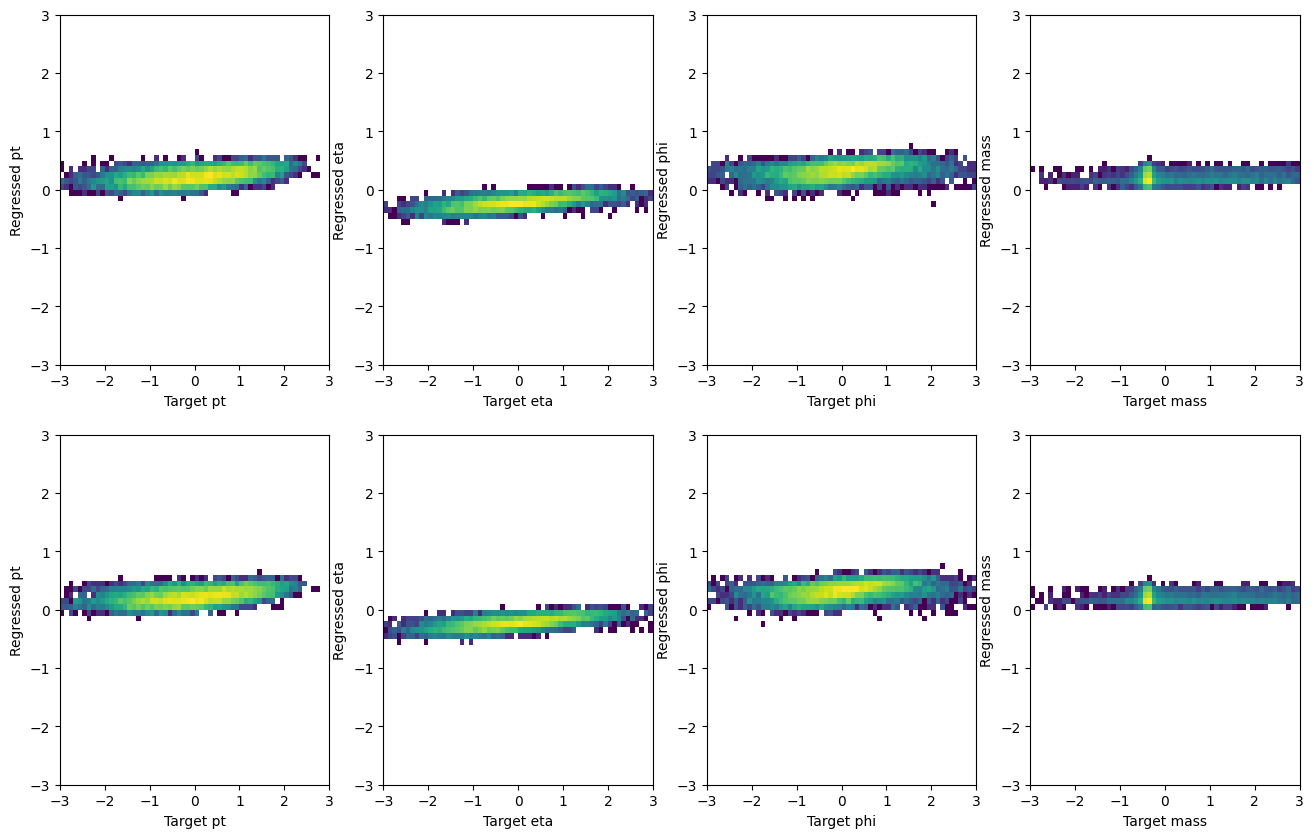

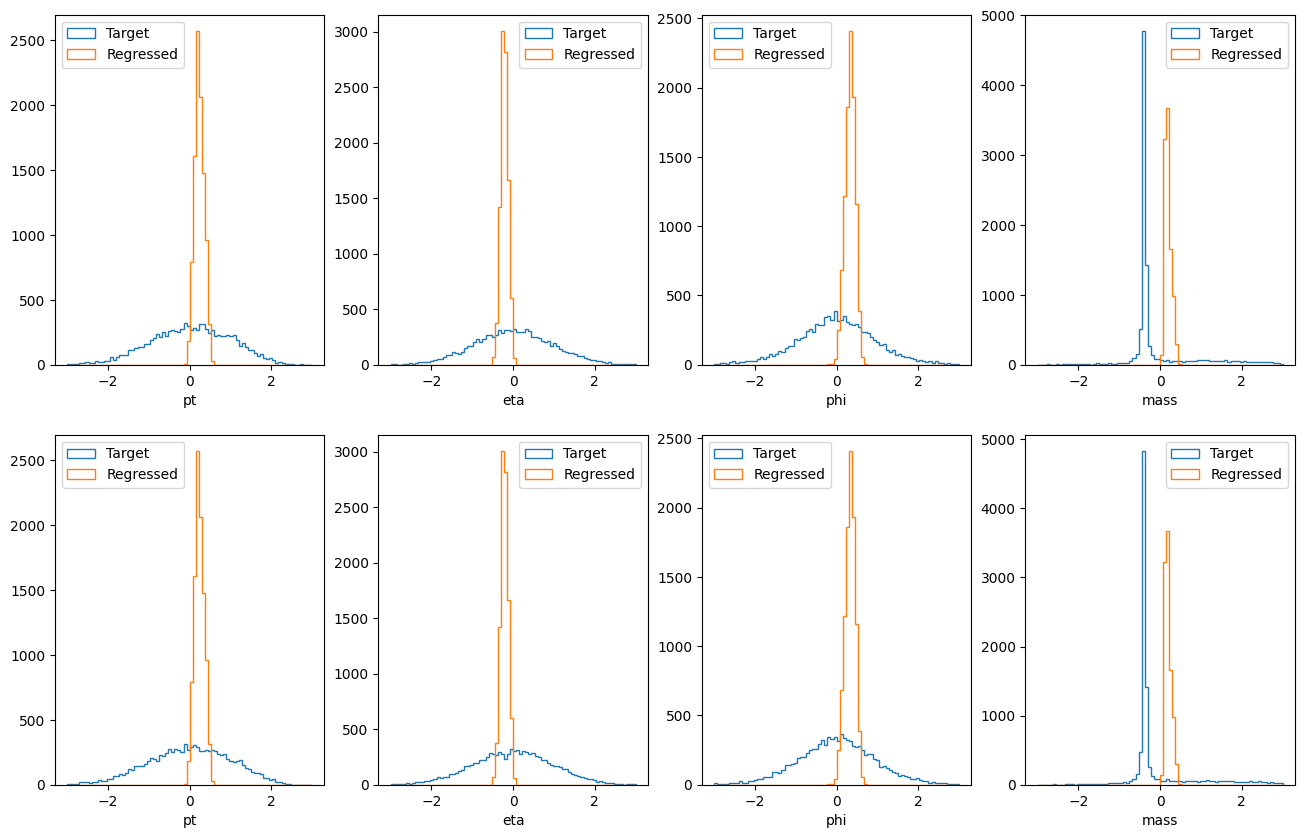

In [16]:
validation_plots(W, W_out)

# Training with MMD loss

Often regressions are biased toward the most probable value. This is a "feature" of the MSE loss.
If the value to regress is not "flat" but has long tails, the regression will often collpapse on the most probable case.

Using an alternative regression loss such as the **Huber loss** [wikipedia](https://en.wikipedia.org/wiki/Huber_loss) can alleviate the problem, but not solve it completely. 

To counteract this problem we can add to the loss a term that is measuring the difference between the distribution of the target variable and the distribution of the output of the regression./



In [17]:
from libs.mmd import MMD

In [42]:
mask_nan = torch.isnan(W_out).any(axis=(1,2))

In [45]:
MMD(W[~mask_nan][:,0,:], W_out[~mask_nan][:,0,:], kernel="multiscale", device=device, dtype=torch.float32)

tensor(2.2286, device='cuda:0')

In [46]:
MMD(W[~mask_nan][:,1,:], W_out[~mask_nan][:,1,:], kernel="multiscale", device=device, dtype=torch.float32)

tensor(2.2416, device='cuda:0')

In [63]:
def train_withMMD(model, device, loader, val_loader,  optimizer, criterion, epochs, experiment=None):
    model.train()
    for epoch in range(epochs):
        model.train()
        for batch_idx, (jets, lepton, met, full_mask, nu, W) in enumerate(loader):
            
            optimizer.zero_grad()
            W_out = model(jets, lepton, met, full_mask)
            mask_nan = torch.isnan(W_out).any(axis=(1,2))
            MMD_loss_1 = MMD(W[~mask_nan][:,0,:], W_out[~mask_nan][:,0,:], kernel="multiscale", device=device, dtype=torch.float32)
            MMD_loss_2 = MMD(W[~mask_nan][:,1,:], W_out[~mask_nan][:,1,:], kernel="multiscale", device=device, dtype=torch.float32)
            loss_huber = criterion(W_out, W).nanmean()
            loss =  loss_huber +  MMD_loss_1 + MMD_loss_2
            
            
            if batch_idx % 100 == 0:
                print(f"epoch {epoch}, step {batch_idx}, Loss: {loss.item():.4f}, loss regr: {loss_huber.item():.4f},  MMD W1: {MMD_loss_1.item():.4f}, MMD W2: {MMD_loss_2.item():.4f} ")
                if exp:
                   experiment.log_metric("train_loss_step", loss.item(), step=batch_idx)
                    
            loss.backward()
            optimizer.step()
        # Log metrics
        if experiment:
            experiment.log_metric("train_loss_epoch", loss.item(), step=epoch)
        
        # Validation loss
        model.eval()
        val_loss = 0.  
        val_loss_huber = 0.
        val_loss_mmd_w1 = 0.
        val_loss_mmd_w2 = 0.
        
        with torch.no_grad():
            for jets_val, lepton_val, met_val ,full_mask_val, nu_val, W_val in val_loader:
                W_out_val = model(jets_val, lepton_val, met_val,full_mask_val)
                loss = criterion(W_out_val, W_val)

                mask_nan_val = torch.isnan(W_out_val).any(axis=(1,2))
                MMD_loss_1_val = MMD(W_val[~mask_nan_val][:,0,:], W_out_val[~mask_nan_val][:,0,:], kernel="multiscale", device=device, dtype=torch.float32)
                MMD_loss_2_val = MMD(W_val[~mask_nan_val][:,1,:], W_out_val[~mask_nan_val][:,1,:], kernel="multiscale", device=device, dtype=torch.float32)
                
                loss_huber_val = criterion(W_out_val, W_val).nanmean()
                val_loss += (loss_huber_val +  MMD_loss_1_val + MMD_loss_1_val).item()
                val_loss_huber += loss_huber_val.item()
                val_loss_mmd_w1 += MMD_loss_1_val.item()
                val_loss_mmd_w2 += MMD_loss_2_val.item()
                
            val_loss = val_loss / len(val_loader)
            val_loss_huber = val_loss_huber / len(val_loader)
            val_loss_mmd_w1 = val_loss_mmd_w1 / len(val_loader)
            val_loss_mmd_w2 = val_loss_mmd_w2 / len(val_loader)
            
            if experiment:
                experiment.log_metric("val_loss_epoch", val_loss.item(), step=epoch)
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}, loss regr: {val_loss_huber:.4f},  MMD W1: {val_loss_mmd_w1:.4f}, MMD W2: {val_loss_mmd_w2:.4f} ")

            #print for one batch
            validation_plots(W_val, W_out_val)
        print(f"End of epoch {epoch}")
    return model

In [ ]:
num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_model = 32
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
learning_rate = 1e-4

model = WWRegressorComplete(d_model, nhead, num_encoder_layers, num_decoder_layers,
                   regression_net=[16])
model.to(device)

print(f"Model with {count_parameters(model)} parameters")

optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)
criterion = torch.nn.HuberLoss(delta=2., reduction='none')

# Create Comet.ml experiment
# exp = Experiment(
#              api_key=comet_token,
#              project_name="PhDCourse",
#              workspace="valsdav",
#              auto_output_logging = "simple",
#              # disabled=True
#          )
# exp.log_parameters({"model_param_tot": count_parameters(model)})

#exp.display(tab='panels')
exp = None

trained_model = train_withMMD(model, device, dataloader_train, dataloader_val, optimizer, criterion, num_epochs)